In [ ]:
########## PACKAGE AND FILE IMPORT ##########

import numpy as np
from numpy.linalg import pinv
from scipy.integrate import solve_ivp
from scipy.linalg import lstsq
import matplotlib.pyplot as plt
# type: ignore[import]
from matplotlib.path import Path  # type: ignore[import]
from matplotlib import colors
from matplotlib.animation import FuncAnimation
import pickle

from fish import Fish
from environment import Environment

In [ ]:
########## DEFINE ENVIRONMENT AND LOAD DATA ##########

# Define fish
num = 7
Nemo_position = np.vstack((np.linspace(0, 0.5, num), np.zeros((num)))) 
Nemo_velocity = np.vstack((-0.75*np.ones(num), np.zeros((num))))
Nemo = Fish(Nemo_position, Nemo_velocity)

# Reinitialize fish position to have reference curvature
angles = Nemo.centerlineScaling * Nemo.waveAmp * np.sin(Nemo.waveNum * Nemo.centerline[1:num-1]) + Nemo.waveOffset
angles = angles.flatten()
current_phi = 0.0
for ii in range(num-1):
    Nemo_position[:, ii+1] = Nemo_position[:, ii] + Nemo.lEdgeRef[ii]*np.array([np.cos(current_phi), np.sin(current_phi)])
    if ii < num-2:
        current_phi += angles[ii]

# Define the environment containing the fish
school = [Nemo]
fish_tank = Environment(school)

# Load simulation outputs
with open('one_fish_output.pkl', 'rb') as f:
    sim_output = pickle.load(f)
with open('one_fish_output_Gamma.pkl', 'rb') as f:
    sim_output_Gamma = pickle.load(f)
with open('one_fish_output_bvs.pkl', 'rb') as f:
    sim_output_bvs = pickle.load(f)
with open('one_fish_output_bvs_gamma.pkl', 'rb') as f:
    sim_output_bvs_gamma = pickle.load(f)

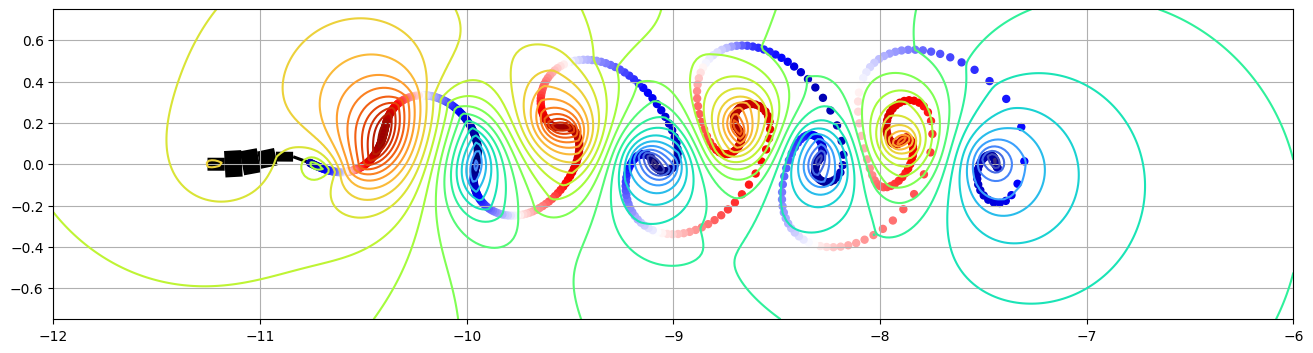

In [17]:
########## PLOT ENVIRONMENT AT ONE TIME INSTANCE ##########

# Preset vortex color maps
all_Gamma = np.concatenate(sim_output_Gamma)
vmin = np.min(all_Gamma)
vmax = np.max(all_Gamma)
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0.0, vmax=vmax)
cmap = plt.get_cmap('seismic') 

# Define figure
fig, ax = plt.subplots(figsize=(16, 9))

# Plot fishies at given time
ii = 3000

# Clear image and update state at each time step
ax.clear()
current_state = sim_output[ii]
current_Gamma = sim_output_Gamma[ii]
current_bvs_positions = sim_output_bvs[ii]
current_bvs_gamma = sim_output_bvs_gamma[ii]

# Plot freestream lines of velocity field
x_targets = np.linspace(-12.0,-6.0,400)
y_targets = np.linspace(-0.75,0.75,100)
X_targets, Y_targets = np.meshgrid(x_targets,y_targets)
Z_targets = X_targets + 1j*Y_targets
potential = np.zeros_like(Z_targets)

# Add contribution of bound vortices to flow potential
Z_sources = current_bvs_positions[0,:] + 1j*current_bvs_positions[1,:]
for ii in range(Nemo.bvs_N):
    potential += current_bvs_gamma[ii] * Nemo.bvs_length[ii] * np.log(Z_targets - Z_sources[ii]) / (2 * np.pi * 1j)

# Plot each fish configuration
start = 0
for fish in [Nemo]:

    end = start + 2*fish.N

    # Get node positions from ODE output
    positions = current_state[start:end].reshape((2,fish.N), order='F')

    # Calculate centerline segment positions and orientations
    midpoints = (positions[:,0:fish.N-1] + positions[:,1:fish.N])/2
    edges = positions[:,1:fish.N] - positions[:,0:fish.N-1]
    tangents = edges/np.linalg.norm(edges, axis=0)
    normals = np.vstack([-tangents[1,:], tangents[0,:]])

    # Caluclate rectangular segment locations 
    southwestPoints = midpoints - 0.5*tangents*fish.lEdgeRef.T - 0.5*normals*fish.hEdgeRef.T
    northwestPoints = midpoints - 0.5*tangents*fish.lEdgeRef.T + 0.5*normals*fish.hEdgeRef.T
    northeastPoints = midpoints + 0.5*tangents*fish.lEdgeRef.T + 0.5*normals*fish.hEdgeRef.T
    southeastPoints = midpoints + 0.5*tangents*fish.lEdgeRef.T - 0.5*normals*fish.hEdgeRef.T

    # Draw rectangular segments
    for jj in range(fish.N-1):
        rectangleX = [southwestPoints[0, jj], northwestPoints[0, jj],
                    northeastPoints[0, jj], southeastPoints[0, jj]]
        rectangleY = [southwestPoints[1, jj], northwestPoints[1, jj],
                    northeastPoints[1, jj], southeastPoints[1, jj]]
        ax.fill(rectangleX, rectangleY, 'k') #, label='Segments' if jj == 0 else "")

    start = end + 2*fish.N

# Plot free vortex street
vortex_data = current_state[start:]
num_vortices = vortex_data.size // 2
free_vortices = vortex_data.reshape((2,num_vortices), order='F')
sc = ax.scatter(free_vortices[0,:], free_vortices[1,:], c=current_Gamma, 
cmap=cmap, norm=norm, s=25)

# Add contributions of free vortices to flow potential
for ii in range(len(current_Gamma)):
    potential += current_Gamma[ii] * np.log(Z_targets - free_vortices[0,ii] - 1j*free_vortices[1,ii]) / (2 * np.pi * 1j)

# Show flow streamlines
plt.contour(X_targets, Y_targets, np.imag(potential), levels=25, cmap="turbo")

# Plotting parameters
plt.xlim(-12.0,-6.0)
plt.ylim(-0.75,0.75)
ax.set_aspect('equal')
ax.grid(True)
# ax.legend()
